Imports

In [6]:
from astropy import units as u
from astropy import constants as c
from astropy.modeling.models import BlackBody, PowerLaw1D

import numpy as np

import matplotlib.pyplot as plt

from utils.frd import elex_transfcnl
from utils.fsl import calc_responsivity, produce_spectra, read_coadd

import h5py

Original inteferogram

Time: 41585542646180000


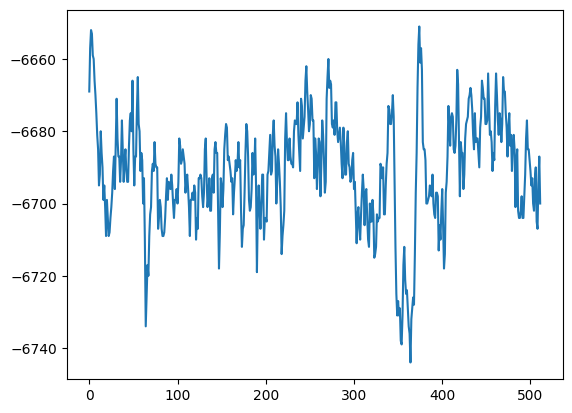

In [7]:
erecno = 170
ifg_ind = 550_000  # this is a pretty good one
# ifg_ind = 55_000

data_orig = h5py.File(
        "/mn/stornext/d16/cmbco/ola/firas/initial_data/fdq_sdf_new.h5"
    )
data_ll = data_orig["fdq_sdf_ll"]
original_ifg = data_ll["ifg_data/ifg"][ifg_ind]

# what is this time
t0 = data_ll["ct_head/time"][ifg_ind]

eng_time = data_ll["dq_data/eng_time"][ifg_ind]
print(f"Time: {eng_time}")

plt.plot(original_ifg)
plt.show()

In [8]:
data_orig_eng = h5py.File(
        "/mn/stornext/d16/cmbco/ola/firas/initial_data/fdq_eng_new.h5"
    )

eng_id = -1
print(len(str(t0)))

arr = list(data_orig_eng["ct_head/time"])

while eng_id < 0:
    try:
        # eng_id = arr.index(t0)
        eng_id = arr.index(str(eng_time))
    except ValueError:
        # t0 = str(t0)[:-1]
        eng_time = str(eng_time)[:-1]
        # print(t0)
        print(eng_time)
        # arr = [str(elem)[:len(t0)] for elem in arr]
        arr = [str(elem)[:len(eng_time)] for elem in arr]

print(eng_id)


17
4158554264618000
546460


Range definition

In [9]:
# dGHz = 17 * u.GHz  # Taken from Explanatory Supplement, page 14 for LRES
dGHz = 4.2 * u.GHz  # Taken from Explanatory Supplement, page 14 for hres
f_GHz = np.arange(1, 513) * dGHz

# dnu = dGHz.to("cm-1", equivalencies=u.spectral())
# nu = np.arange(1, 513) * dnu

# x_max = dnu.to("cm", equivalencies=u.spectral())
# dx = x_max / 512
# x = np.arange(1, 513) * dx

x = np.arange(1, 513)

nu = 1 / x
nu_max = max(nu)
nu = np.arange(1, 513) * nu_max / 512

# x0 = (max(x) + min(x)) / 2
x0 = x[360] # page 37 of the explanatory supplement for LLSS RLSS

In [10]:
def transform_to_ifg(sky, bb_ical):
    diff = - sky.to("erg s-1 cm-2 Hz-1 sr-1", equivalencies=u.brightness_temperature(f_GHz)) + bb_ical.to("erg s-1 cm-2 Hz-1 sr-1", equivalencies=u.brightness_temperature(f_GHz))

    ifg = np.zeros(len(x))

    for i in range(len(x)):
        # ifg[i] = np.sum(diff.value * np.cos(2 * np.pi * nu.value * (x[i].value - x0.value)))
        ifg[i] = np.sum(diff.value * np.cos(2 * np.pi * nu * (x[i] - x0)))

    # ifg = ifg * (u.erg / u.s / u.cm**2 / u.Hz / u.sr)

    return diff, ifg

Black body definitions

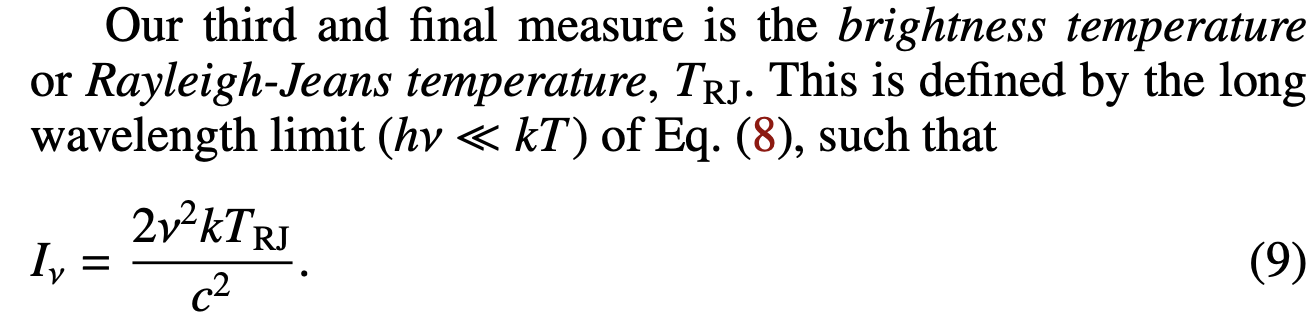
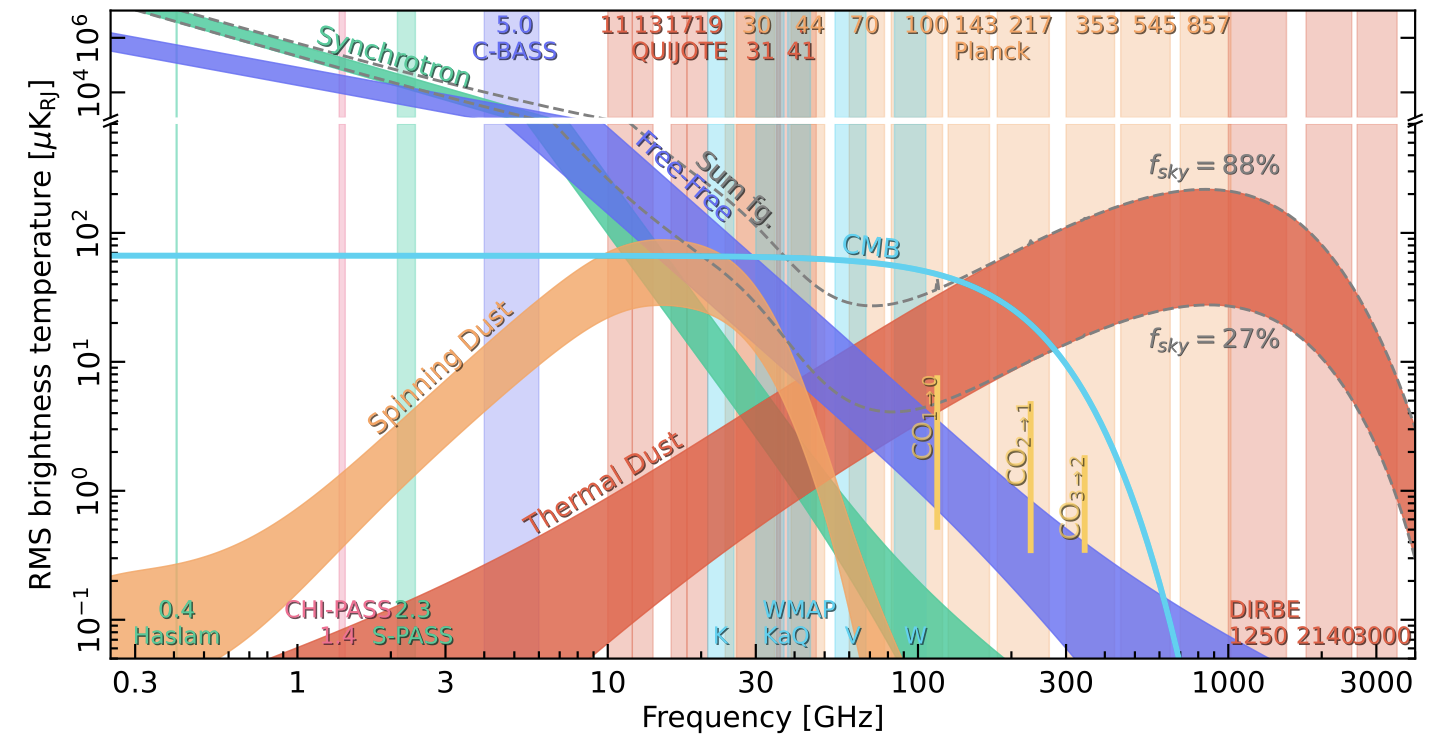
(BeyondPlanck I. Global Bayesian analysis of the Planck Low Frequency Instrument data)

In [11]:
t_cmb = 2.72548 * u.K  # Fixsen, 2009

bb_cmb = BlackBody(t_cmb)
bb_cmb = bb_cmb(f_GHz)
# bb_cmb = bb_cmb.to("erg s-1 cm-2 Hz-1 sr-1", equivalencies=u.spectral_density(f_GHz))
bb_cmb = bb_cmb.to(u.uK, equivalencies=u.brightness_temperature(f_GHz))

t_ical = (0.1 * data_orig_eng["en_analog/grt/a_hi_ical"][eng_id] + 0.9 * data_orig_eng["en_analog/grt/b_hi_ical"][eng_id]) * u.K

print(t_ical)

# bb_ical = BlackBody(2.76 * u.K)
bb_ical = BlackBody(t_ical)
bb_ical = 0.96 * bb_ical(f_GHz)
# bb_ical = bb_ical.to("erg s-1 cm-2 Hz-1 sr-1", equivalencies=u.spectral_density(f_GHz))
bb_ical = bb_ical.to(u.uK, equivalencies=u.brightness_temperature(f_GHz))

[2.7514012] K


Inteferogram

In [12]:
diff, ifg = transform_to_ifg(bb_cmb, bb_ical)

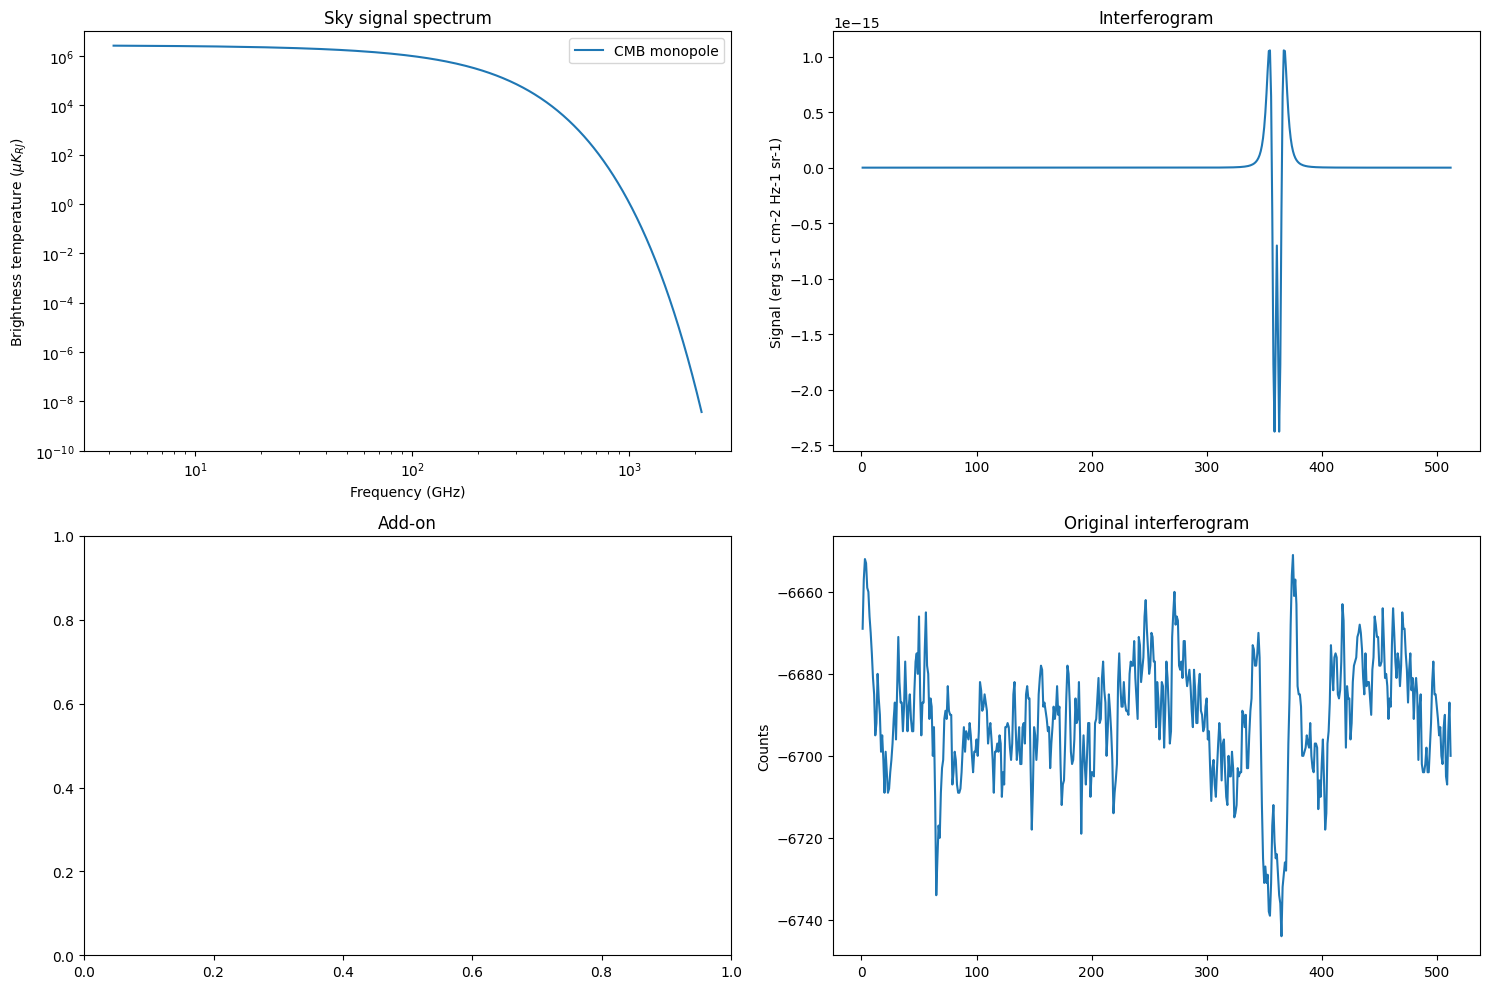

In [13]:
fig, ax = plt.subplots(2,2, figsize=(15,10))

ax[0,0].plot(f_GHz, bb_cmb, label="CMB monopole")
# ax[0,0].plot(f_GHz, bb_cmb - t_cmb, label="CMB")
ax[0,0].set_xlabel("Frequency (GHz)")
# ax[0,0].set_ylabel("Signal (erg s-1 cm-2 Hz-1 sr-1)")
ax[0,0].set_ylabel("Brightness temperature ($\mu K_{RJ}$)")
ax[0,0].set_title("Sky signal spectrum")
ax[0,0].set_yscale("log")
ax[0,0].set_xscale("log")
ax[0,0].set_ylim(1e-10,1e7)
ax[0,0].legend()

ax[1,0].set_title("Add-on")

ax[0,1].plot(x, ifg)
# ax[1].set_xlabel("Optical path (cm)")
ax[0,1].set_ylabel("Signal (erg s-1 cm-2 Hz-1 sr-1)")
ax[0,1].set_title("Interferogram")
# ax[0,1].set_ylim(-2e-14,5e-14)

ax[1,1].plot(x, original_ifg)
# ax[2].set_xlabel("Optical path (cm)")
ax[1,1].set_ylabel("Counts")
ax[1,1].set_title("Original interferogram")

plt.tight_layout()
plt.show()

CMB anisotropies

In [14]:
dt = 3.5 * u.mK

cmb_anisotropies = bb_cmb * np.exp(c.h * f_GHz / (c.k_B * t_cmb)) / (np.exp(c.h * f_GHz / (c.k_B * t_cmb)) - 1) * c.h * f_GHz / c.k_B / t_cmb ** 2 * dt
cmb_anisotropies = cmb_anisotropies.to(u.uK, equivalencies=u.brightness_temperature(f_GHz))

In [15]:
sky = bb_cmb + cmb_anisotropies

diff, ifg = transform_to_ifg(sky, bb_ical)

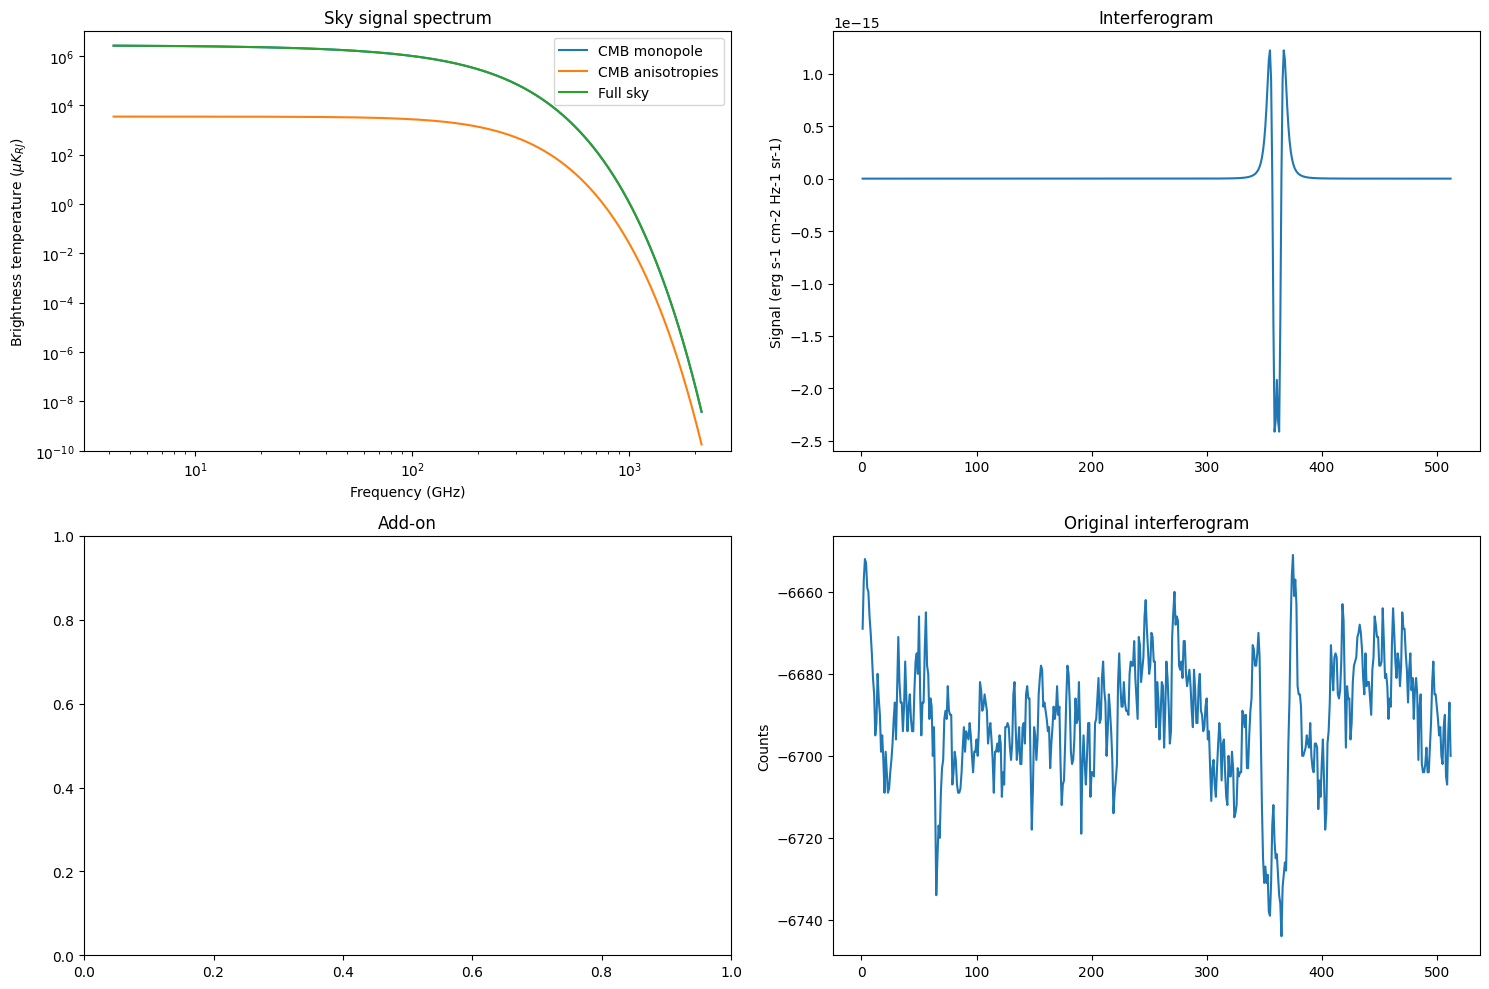

In [16]:
fig, ax = plt.subplots(2,2, figsize=(15,10))

ax[0,0].plot(f_GHz, bb_cmb, label="CMB monopole")
ax[0,0].plot(f_GHz, cmb_anisotropies, label="CMB anisotropies")
ax[0,0].plot(f_GHz, sky, label="Full sky")
# ax[0,0].plot(f_GHz, bb_cmb - t_cmb, label="CMB")
ax[0,0].set_xlabel("Frequency (GHz)")
# ax[0,0].set_ylabel("Signal (erg s-1 cm-2 Hz-1 sr-1)")
ax[0,0].set_ylabel("Brightness temperature ($\mu K_{RJ}$)")
ax[0,0].set_title("Sky signal spectrum")
ax[0,0].set_yscale("log")
ax[0,0].set_xscale("log")
ax[0,0].set_ylim(1e-10,1e7)
ax[0,0].legend()

ax[1,0].set_title("Add-on")

ax[0,1].plot(x, ifg)
# ax[1].set_xlabel("Optical path (cm)")
ax[0,1].set_ylabel("Signal (erg s-1 cm-2 Hz-1 sr-1)")
ax[0,1].set_title("Interferogram")
# ax[0,1].set_ylim(-2e-14,5e-14)

ax[1,1].plot(x, original_ifg)
# ax[2].set_xlabel("Optical path (cm)")
ax[1,1].set_ylabel("Counts")
ax[1,1].set_title("Original interferogram")

plt.tight_layout()
plt.show()

Synchrotron radiation

In [17]:
beta_synch = -3.07 
nu0_synch = 408 * u.MHz

# S_v0 = 1.0 * u.erg / u.s / u.cm**2 / u.Hz / u.sr
amplitude_synch = 30 * u.K

synchrotron = amplitude_synch * (f_GHz / nu0_synch)**beta_synch
synchrotron = synchrotron.to(u.uK, equivalencies=u.brightness_temperature(f_GHz))
# synchrotron = synchrotron.to("erg s-1 cm-2 Hz-1 sr-1", equivalencies=u.brightness_temperature(f_GHz))

In [18]:
sky = bb_cmb + cmb_anisotropies + synchrotron

_, ifg = transform_to_ifg(sky, bb_ical)

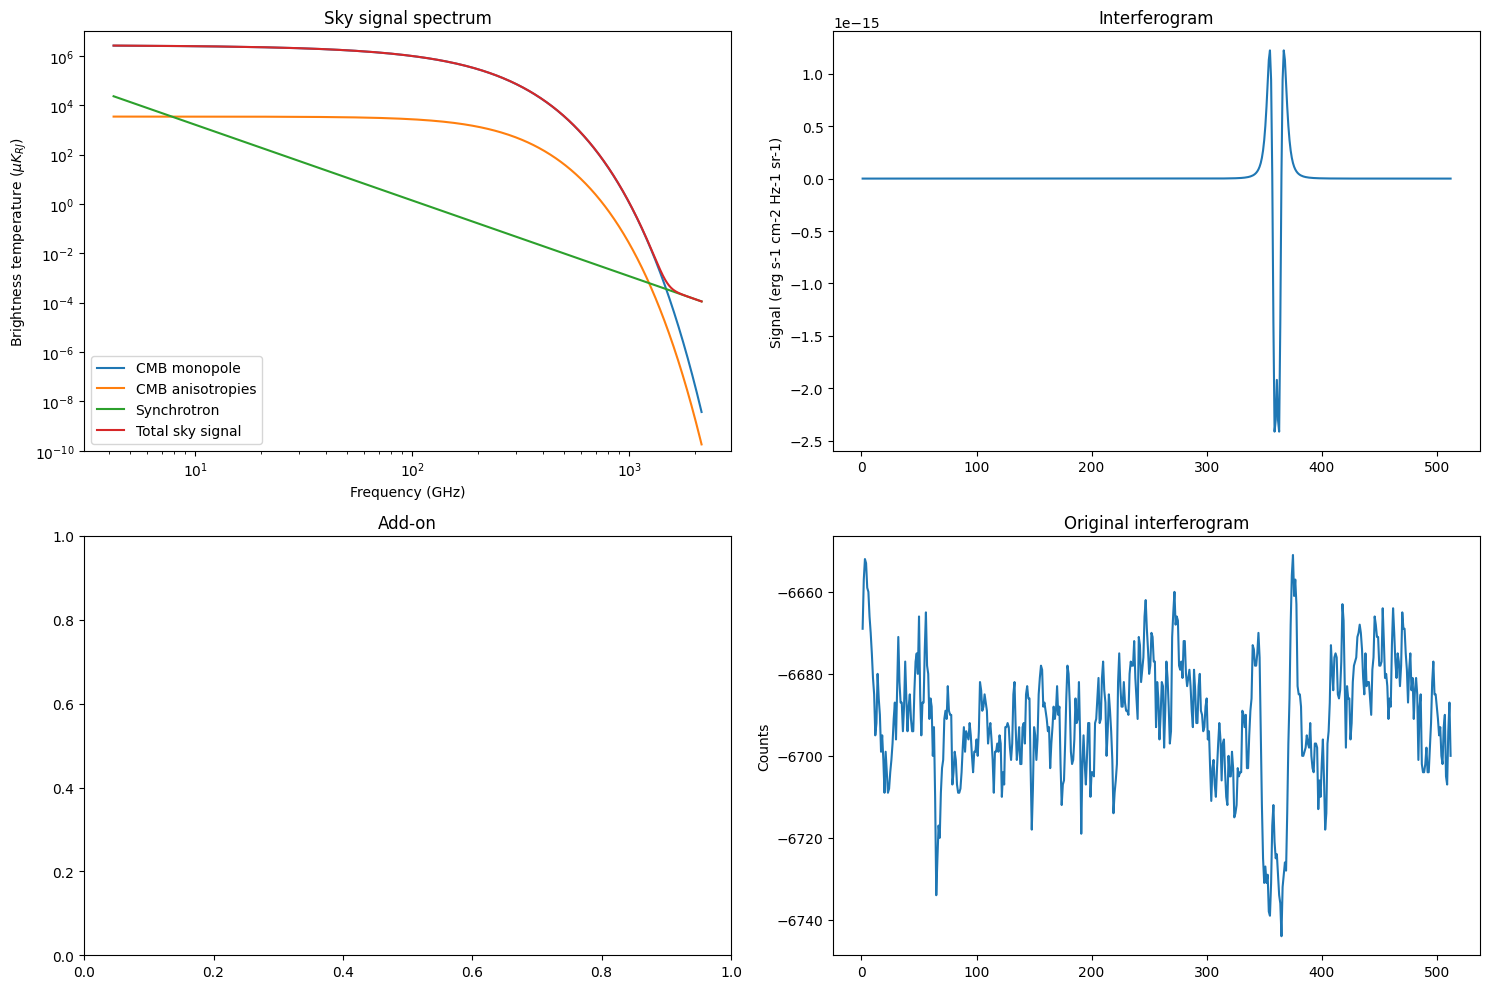

In [19]:
fig, ax = plt.subplots(2,2, figsize=(15,10))

ax[0,0].plot(f_GHz, bb_cmb, label="CMB monopole")
ax[0,0].plot(f_GHz, cmb_anisotropies, label="CMB anisotropies")
ax[0,0].plot(f_GHz, synchrotron, label="Synchrotron")
ax[0,0].plot(f_GHz, sky, label="Total sky signal")
ax[0,0].set_xlabel("Frequency (GHz)")
ax[0,0].set_ylabel("Brightness temperature ($\mu K_{RJ}$)")
ax[0,0].set_title("Sky signal spectrum")
ax[0,0].set_ylim(1e-10,1e7)
ax[0,0].set_yscale("log")
ax[0,0].set_xscale("log")
ax[0,0].legend()

ax[1,0].set_title("Add-on")

ax[0,1].plot(x, ifg)
# ax[1].set_xlabel("Optical path (cm)")
ax[0,1].set_ylabel("Signal (erg s-1 cm-2 Hz-1 sr-1)")
ax[0,1].set_title("Interferogram")
# ax[0,1].set_ylim(-2e-14,5e-14)

ax[1,1].plot(x, original_ifg)
# ax[2].set_xlabel("Optical path (cm)")
ax[1,1].set_ylabel("Counts")
ax[1,1].set_title("Original interferogram")

plt.tight_layout()
plt.show()

Thermal dust

In [20]:
# Planck 2013 results. XI. All-sky model of thermal dust emission
nu0_dust = 353 * u.GHz
beta_dust = 1.62
t_dust = 19.7 * u.K
optical_depth_nu0 = 9.6 * 10**(-7)

dust_bb = BlackBody(t_dust)
dust = optical_depth_nu0 * dust_bb(f_GHz) * (f_GHz / nu0_dust)**beta_dust
# dust = dust.to("erg s-1 cm-2 Hz-1 sr-1", equivalencies=u.brightness_temperature(f_GHz))
dust = dust.to(u.uK, equivalencies=u.brightness_temperature(f_GHz))

In [21]:
sky = bb_cmb + cmb_anisotropies + synchrotron + dust

diff, ifg = transform_to_ifg(sky, bb_ical)
save_ifg = ifg

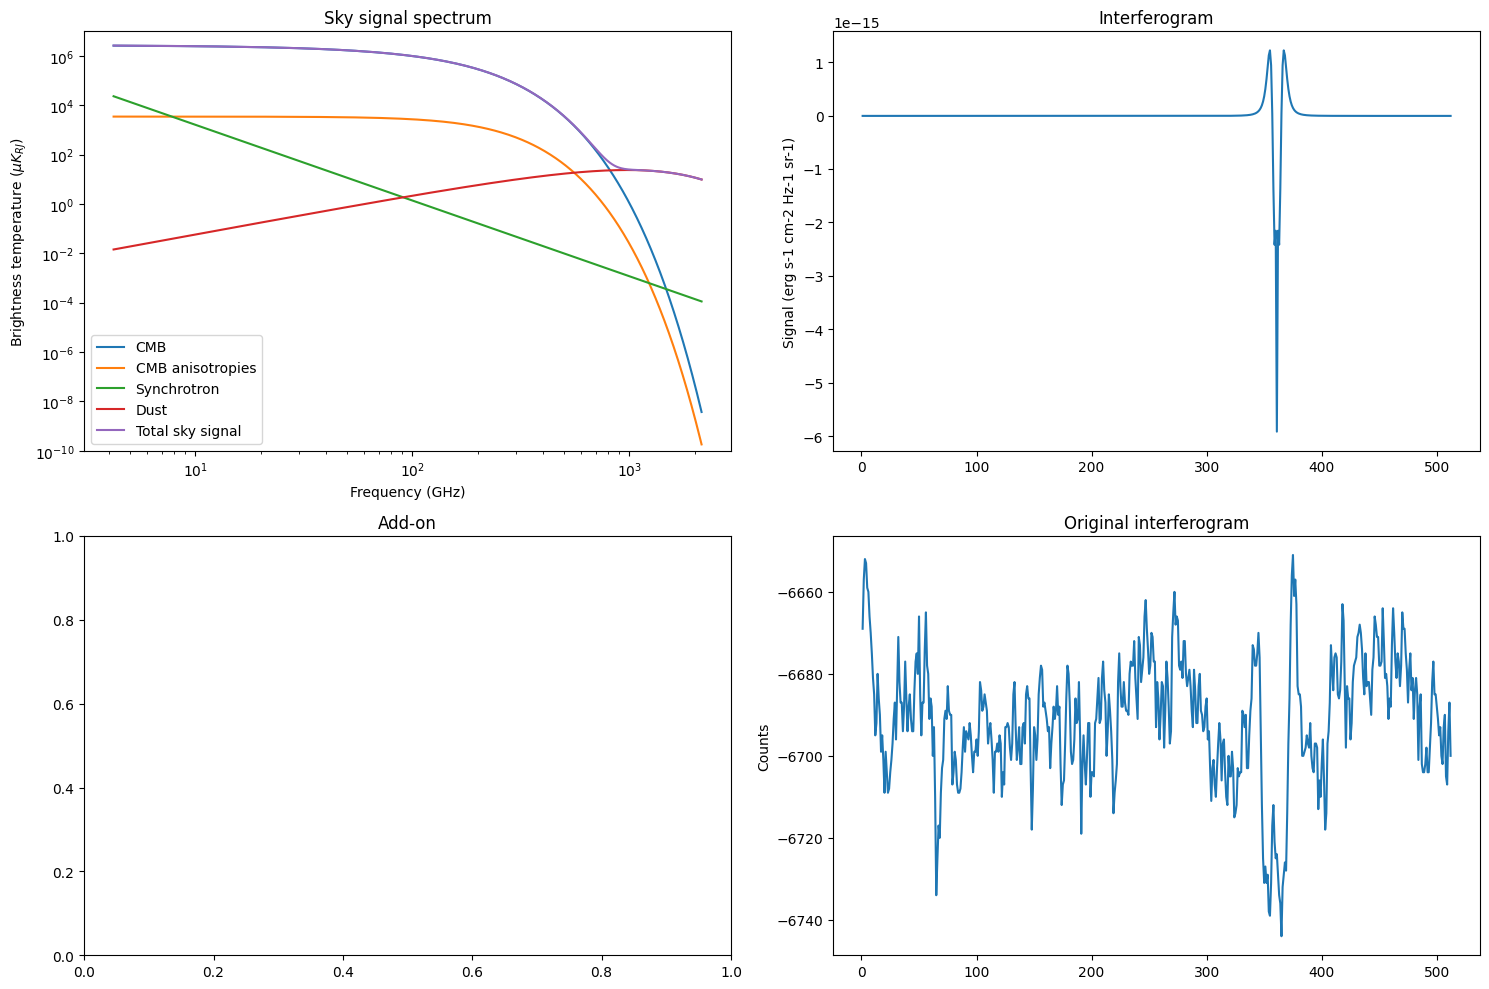

In [22]:
fig, ax = plt.subplots(2,2, figsize=(15,10))

ax[0,0].plot(f_GHz, bb_cmb, label="CMB")
ax[0,0].plot(f_GHz, cmb_anisotropies, label="CMB anisotropies")
ax[0,0].plot(f_GHz, synchrotron, label="Synchrotron")
ax[0,0].plot(f_GHz, dust, label="Dust")
ax[0,0].plot(f_GHz, sky, label="Total sky signal")
ax[0,0].set_xlabel("Frequency (GHz)")
ax[0,0].set_ylabel("Brightness temperature ($\mu K_{RJ}$)")
ax[0,0].set_title("Sky signal spectrum")
ax[0,0].set_xscale("log")
ax[0,0].set_yscale("log")
ax[0,0].set_ylim(1e-10,1e7)
ax[0,0].legend()

ax[1,0].set_title("Add-on")

ax[0,1].plot(x, ifg)

# ax[1].set_xlabel("Optical path (cm)")
ax[0,1].set_ylabel("Signal (erg s-1 cm-2 Hz-1 sr-1)")
ax[0,1].set_title("Interferogram")
# ax[0,1].set_ylim(-2e-14,5e-14)

ax[1,1].plot(x, original_ifg)
# ax[2].set_xlabel("Optical path (cm)")
ax[1,1].set_ylabel("Counts")
ax[1,1].set_title("Original interferogram")

plt.tight_layout()
plt.show()

Adding ETF

In [23]:
# Got the samprate directly from the file /mn/stornext/d5/data/duncanwa/FIRAS/firas_analysis_original/firas_pipeline/reference/fex_samprate.txt
etf = elex_transfcnl(samprate=681.43, nfreq=512)

# etf = etf[np.random.randint(0, len(etf))]
etf = etf[erecno]

# We multiply the spectrum of the radiation sources by the ETF, as described in page 461 of Fixsen 1993
diff = diff * etf

ifg = np.zeros(len(x))

for i in range(len(x)):
    ifg[i] = np.sum(diff.value * np.cos(2 * np.pi * nu * (x[i] - x0)))

ifg = ifg * (u.erg / u.s / u.cm**2 / u.Hz / u.sr)


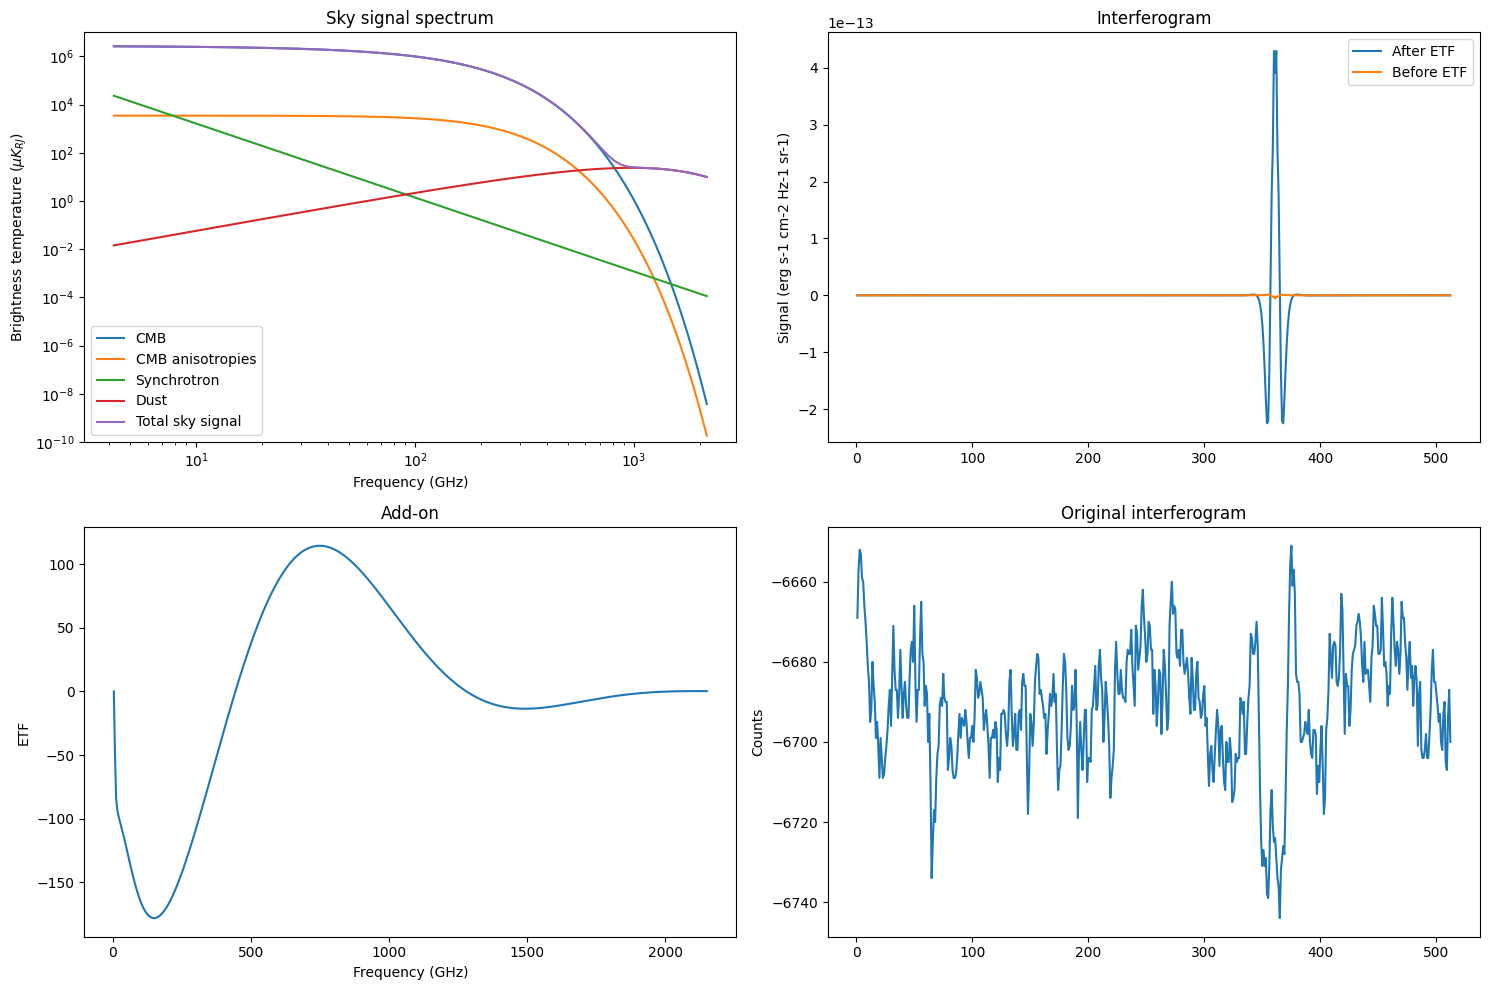

In [24]:
fig, ax = plt.subplots(2,2, figsize=(15,10))

ax[0,0].plot(f_GHz, bb_cmb, label="CMB")
ax[0,0].plot(f_GHz, cmb_anisotropies, label="CMB anisotropies")
ax[0,0].plot(f_GHz, synchrotron, label="Synchrotron")
ax[0,0].plot(f_GHz, dust, label="Dust")
ax[0,0].plot(f_GHz, sky, label="Total sky signal")
ax[0,0].set_xlabel("Frequency (GHz)")
ax[0,0].set_ylabel("Brightness temperature ($\mu K_{RJ}$)")
ax[0,0].set_title("Sky signal spectrum")
ax[0,0].set_xscale("log")
ax[0,0].set_yscale("log")
ax[0,0].set_ylim(1e-10,1e7)
ax[0,0].legend()

ax[1,0].plot(f_GHz, etf)
ax[1,0].set_xlabel("Frequency (GHz)")
ax[1,0].set_ylabel("ETF")
ax[1,0].set_title("Add-on")


ax[0,1].plot(x, ifg, label="After ETF")
ax[0,1].plot(x, save_ifg, label="Before ETF")
# ax[1].set_xlabel("Optical path (cm)")
ax[0,1].set_ylabel("Signal (erg s-1 cm-2 Hz-1 sr-1)")
ax[0,1].set_title("Interferogram")
# ax[0,1].set_ylim(-6e-12, 5e-12)
ax[0,1].legend()

ax[1,1].plot(x, original_ifg)
# ax[2].set_xlabel("Optical path (cm)")
ax[1,1].set_ylabel("Counts")
ax[1,1].set_title("Original interferogram")

plt.tight_layout()
plt.show()

Bolometer model

In [25]:
# S0 = 1e9 * u.A
# omega = 2 * np.pi * f_GHz
# tau = 1e-3 * u.s

# bolometer = S0 / (1 + 1j * omega * tau)

In [26]:
# coadd_recs = read_coadd(args.fil_path, args.channel, args.scan_mode, config, input_type=args.input, quality=quality)
# vspec_rec  = produce_spectra(coadd_recs[j], chan, scan_mode, apodl_all, etfl_all) 
# bol_volt = vspec_rec['coad_spec_data']['bol_volt']

# tbol, qrad, S0, tau = calc_responsivity(bol_volt, cmd_bias, tdet, model['bolparm'])

In [27]:
bol_volt = data_orig_eng["en_analog/group1/bol_volt"][eng_id, 3]
Tbol = (data_orig_eng["en_analog/grt/a_lo_bol_assem"][eng_id, 3] + data_orig_eng["en_analog/grt/b_lo_bol_assem"][eng_id, 3]) / 2
cmd_bias = data_orig_eng["en_stat/bol_cmd_bias"][eng_id, 3]

In [28]:
rscale = 1.0e-7 

# RL = 4.0e7 
RL = 40e6 # Calibration of the COBE FIRAS instrument (Fixsen et al. 1994) - 40 MOhm

# set by me
Jo = 0
Jg = 1.0

V = (bol_volt - Jo) / Jg

G1 = 1.0e-8
beta = 1
G = G1*Tbol**beta
rho = 1

X = V*rho

H = Tbol / X * np.tanh(X/Tbol)

T0 = 100.0

DT = 1.0/H - 1.0 - 0.5*np.sqrt(T0/Tbol)

R = RL*V / (cmd_bias - V)
Z = (G*Tbol*R + DT*V**2) / (G*Tbol*R/H - DT*V**2)

S0 = rscale * R * (Z-H) / (V * (Z*R/RL + 1.0) * (H + 1.0))

In [29]:
C3 = 1.0e-10
C1 = 1.0e-10

C = C3*Tbol**3 + C1*Tbol

tau = C/G * (Z+1.0) * (R*H + RL) / ((Z*R + RL) * (H + 1.0))

In [30]:
omega = 2 * np.pi * f_GHz

bolometer = S0 / (1 + 1j * omega.value * tau)

In [31]:
diff = diff * bolometer

ifg = np.zeros(len(x))

for i in range(len(x)):
    ifg[i] = np.sum(diff.value * np.cos(2 * np.pi * nu * (x[i] - x0)))

ifg = ifg * (u.erg / u.s / u.cm**2 / u.Hz / u.sr)

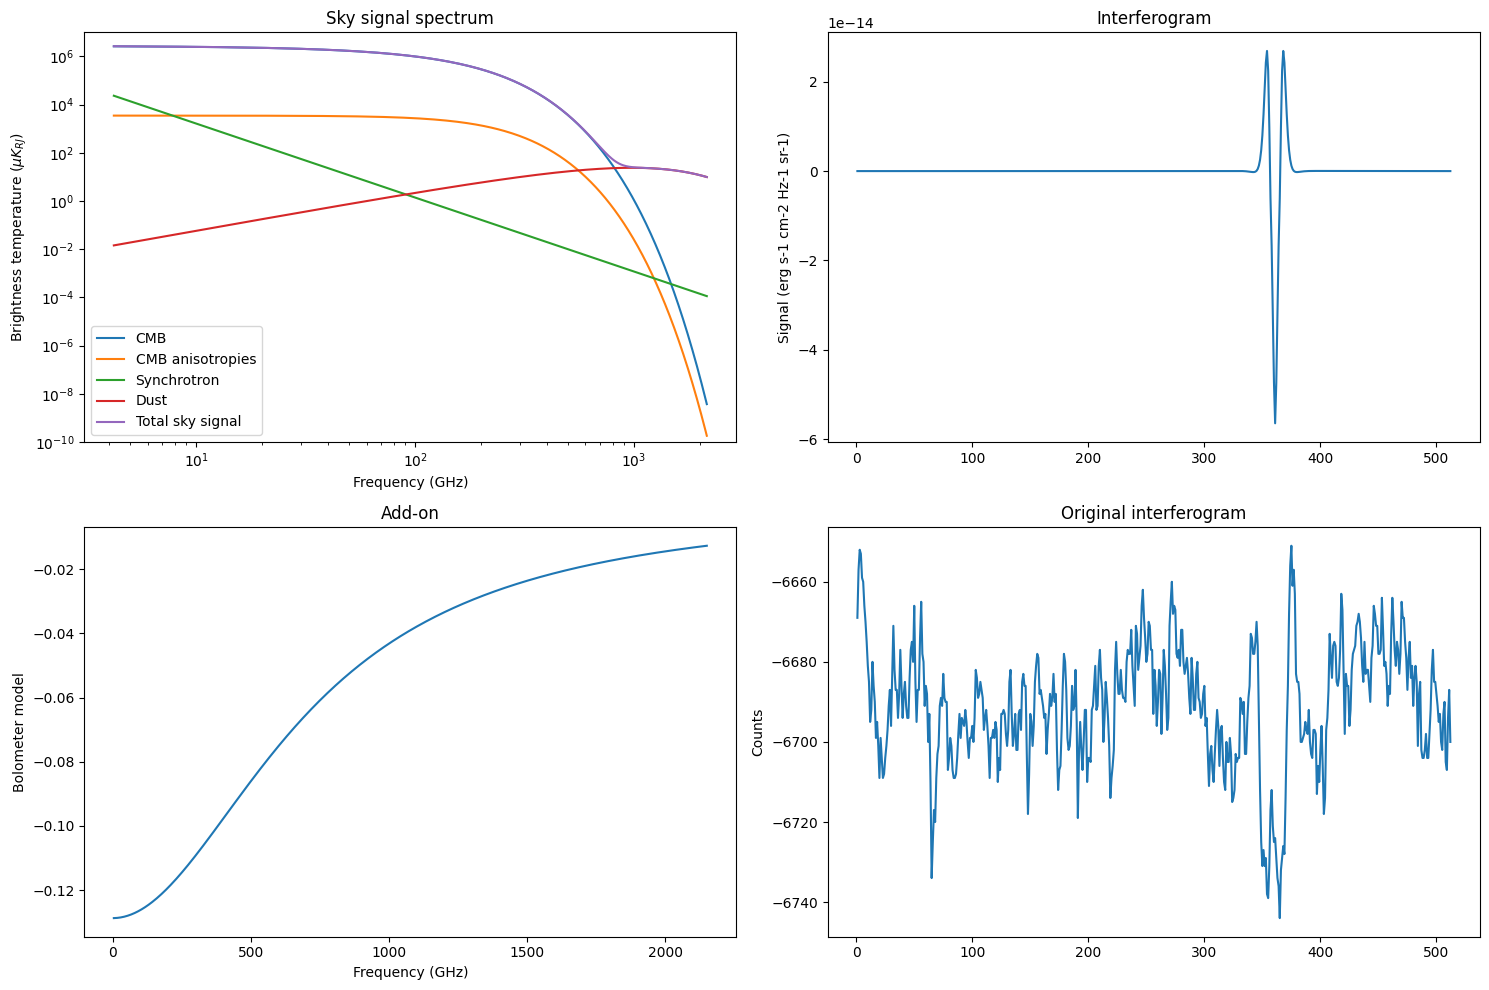

In [32]:
fig, ax = plt.subplots(2,2, figsize=(15,10))

ax[0,0].plot(f_GHz, bb_cmb, label="CMB")
ax[0,0].plot(f_GHz, cmb_anisotropies, label="CMB anisotropies")
ax[0,0].plot(f_GHz, synchrotron, label="Synchrotron")
ax[0,0].plot(f_GHz, dust, label="Dust")
ax[0,0].plot(f_GHz, sky, label="Total sky signal")
ax[0,0].set_xlabel("Frequency (GHz)")
ax[0,0].set_ylabel("Brightness temperature ($\mu K_{RJ}$)")
ax[0,0].set_title("Sky signal spectrum")
ax[0,0].set_xscale("log")
ax[0,0].set_yscale("log")
ax[0,0].set_ylim(1e-10,1e7)
ax[0,0].legend()

ax[1,0].plot(f_GHz, bolometer)
ax[1,0].set_xlabel("Frequency (GHz)")
ax[1,0].set_ylabel("Bolometer model")
ax[1,0].set_title("Add-on")


ax[0,1].plot(x, ifg)
# ax[1].set_xlabel("Optical path (cm)")
ax[0,1].set_ylabel("Signal (erg s-1 cm-2 Hz-1 sr-1)")
ax[0,1].set_title("Interferogram")
# ax[0,1].set_ylim(-6e-12, 5e-12)

ax[1,1].plot(x, original_ifg)
# ax[2].set_xlabel("Optical path (cm)")
ax[1,1].set_ylabel("Counts")
ax[1,1].set_title("Original interferogram")

plt.tight_layout()
plt.show()

1/f noise

In [33]:
kmin = 0
kmax = 512

ck = [0]
cnk = []
for k in range(1, kmax):
    fk = (k * len(x) / (2*np.pi))
    phase = np.random.uniform(0, 2*np.pi)
    ck.append(1/np.abs(fk) * np.cos(phase) * 1e-12)

diff = diff.value + ck

ifg = np.zeros(len(x))

for i in range(len(x)):
    ifg[i] = np.sum(diff * np.cos(2 * np.pi * nu * (x[i] - x0)))

ifg = ifg * (u.erg / u.s / u.cm**2 / u.Hz / u.sr)

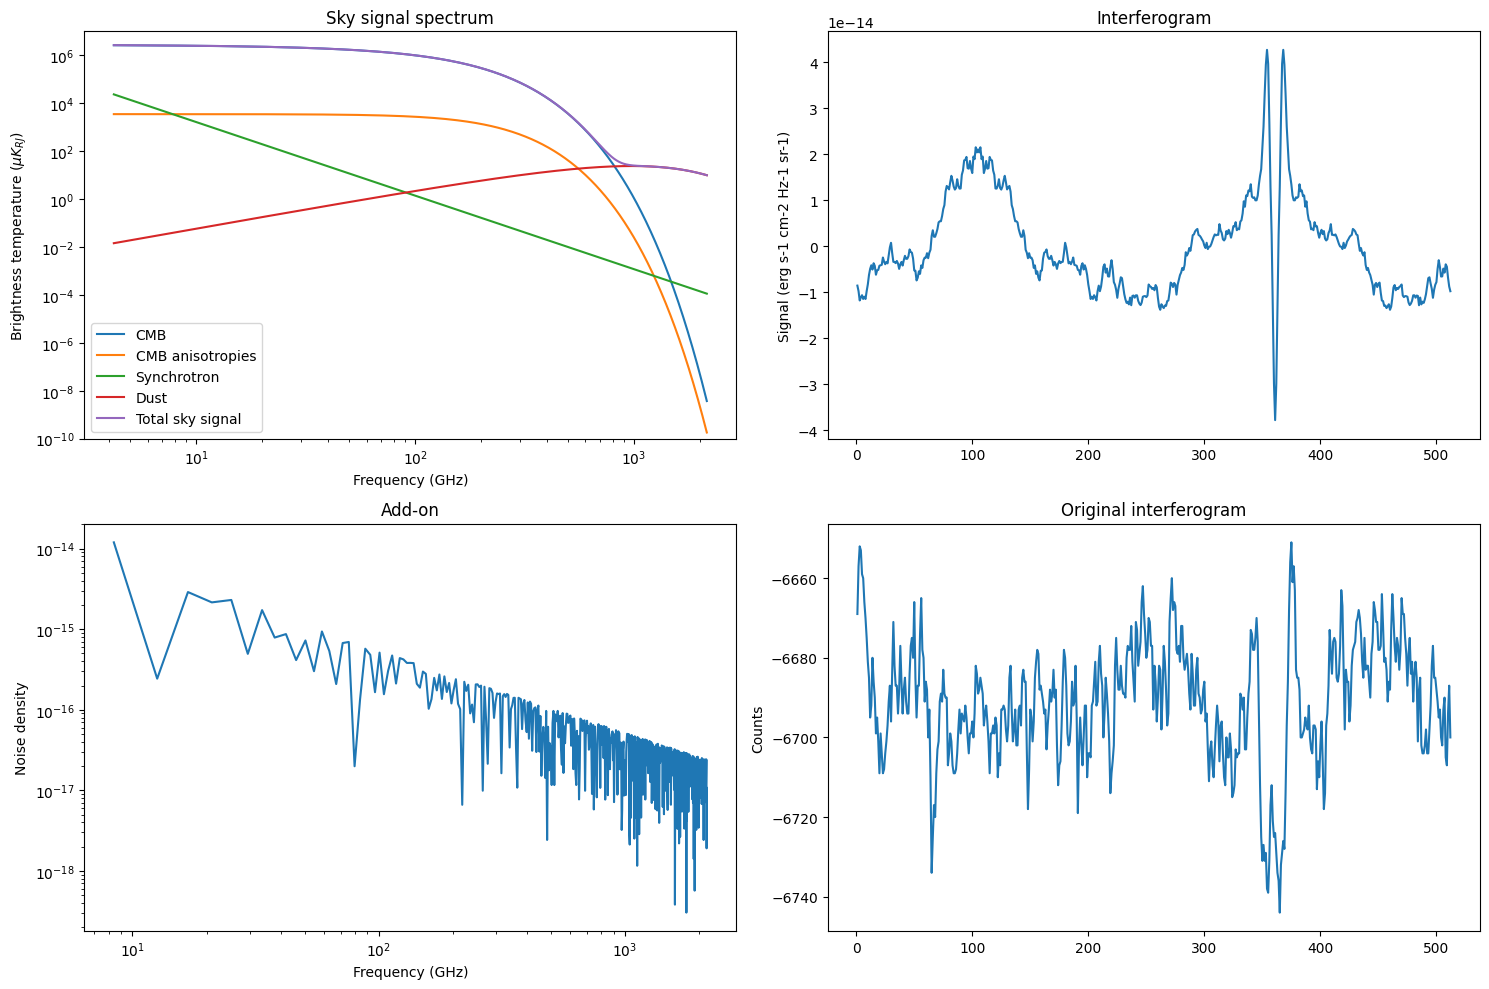

In [34]:
fig, ax = plt.subplots(2,2, figsize=(15,10))

ax[0,0].plot(f_GHz, bb_cmb, label="CMB")
ax[0,0].plot(f_GHz, cmb_anisotropies, label="CMB anisotropies")
ax[0,0].plot(f_GHz, synchrotron, label="Synchrotron")
ax[0,0].plot(f_GHz, dust, label="Dust")
ax[0,0].plot(f_GHz, sky, label="Total sky signal")
ax[0,0].set_xlabel("Frequency (GHz)")
ax[0,0].set_ylabel("Brightness temperature ($\mu K_{RJ}$)")
ax[0,0].set_title("Sky signal spectrum")
ax[0,0].set_xscale("log")
ax[0,0].set_yscale("log")
ax[0,0].set_ylim(1e-10,1e7)
ax[0,0].legend()

# ax[1,0].plot(x, noise1f)
ax[1,0].plot(f_GHz[1:], np.abs(ck[1:]))
ax[1,0].set_title("Add-on")
ax[1,0].set_xscale("log")
ax[1,0].set_yscale("log")
ax[1,0].set_xlabel("Frequency (GHz)")
ax[1,0].set_ylabel("Noise density")

ax[0,1].plot(x, ifg)
# ax[1].set_xlabel("Optical path (cm)")
ax[0,1].set_ylabel("Signal (erg s-1 cm-2 Hz-1 sr-1)")
ax[0,1].set_title("Interferogram")
# ax[0,1].set_ylim(-6e-12, 5e-12)

ax[1,1].plot(x, original_ifg)
# ax[2].set_xlabel("Optical path (cm)")
ax[1,1].set_ylabel("Counts")
ax[1,1].set_title("Original interferogram")

plt.tight_layout()
plt.show()

Adding white noise

In [35]:
# estimation for level of white noise
max_signal = 50
max_noise = 5

noise_level = max(abs(ifg)).value * max_noise / max_signal

noise = np.random.normal(0, noise_level, len(x)) * (u.erg / u.s / u.cm**2 / u.Hz / u.sr)

ifg = ifg + noise

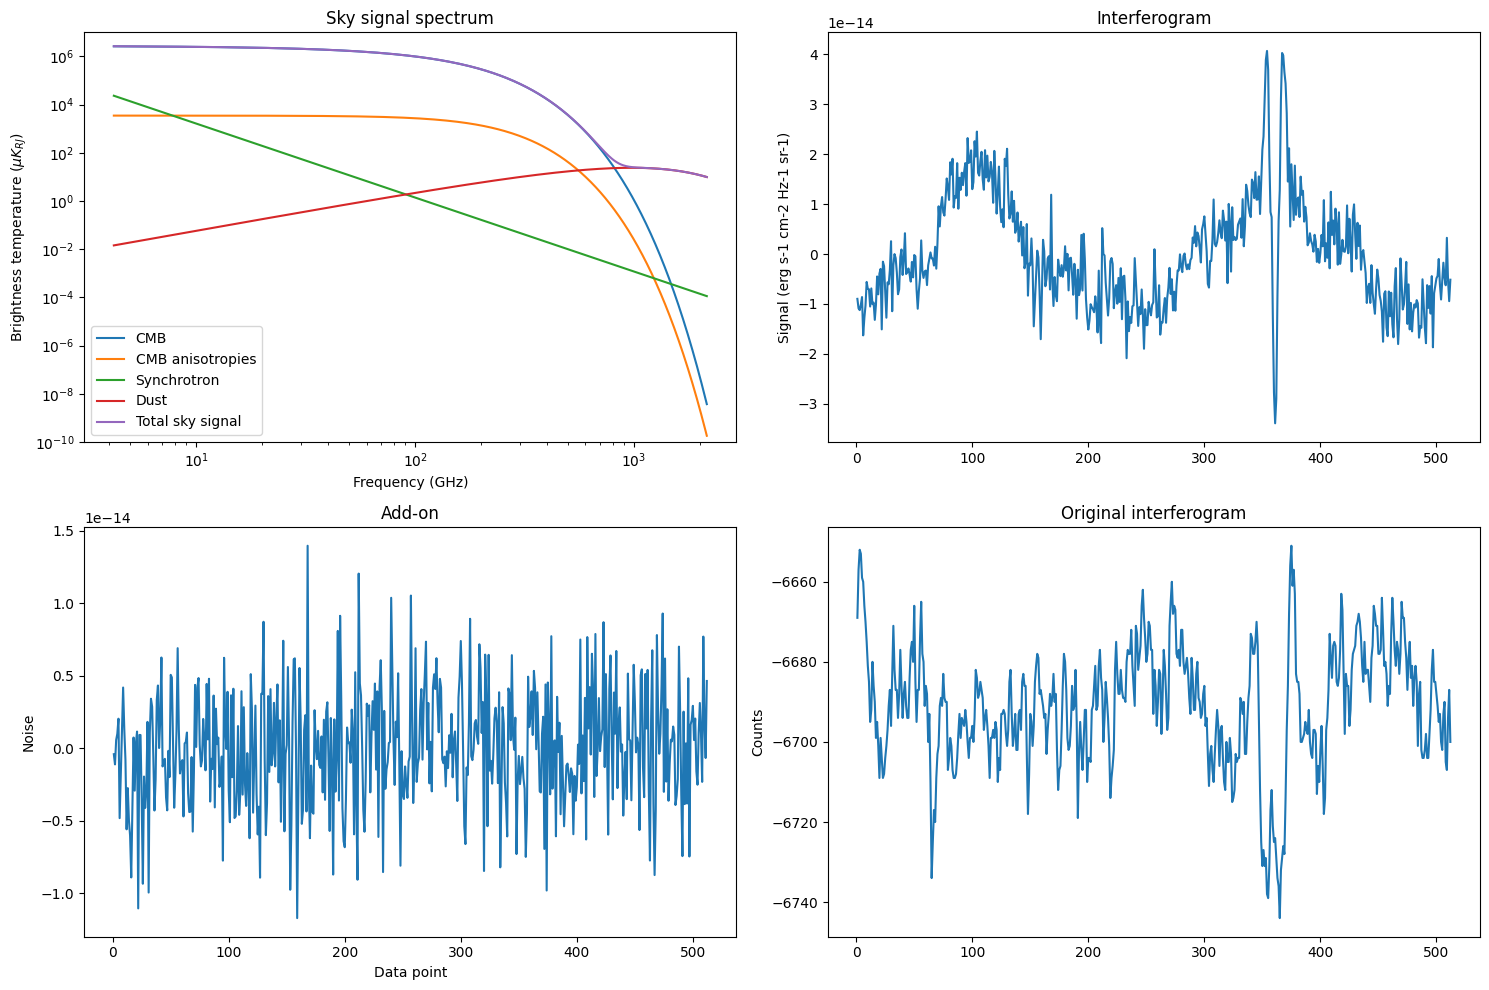

In [36]:
fig, ax = plt.subplots(2,2, figsize=(15,10))

ax[0,0].plot(f_GHz, bb_cmb, label="CMB")
ax[0,0].plot(f_GHz, cmb_anisotropies, label="CMB anisotropies")
ax[0,0].plot(f_GHz, synchrotron, label="Synchrotron")
ax[0,0].plot(f_GHz, dust, label="Dust")
ax[0,0].plot(f_GHz, sky, label="Total sky signal")
ax[0,0].set_xlabel("Frequency (GHz)")
ax[0,0].set_ylabel("Brightness temperature ($\mu K_{RJ}$)")
ax[0,0].set_title("Sky signal spectrum")
ax[0,0].set_xscale("log")
ax[0,0].set_yscale("log")
ax[0,0].set_ylim(1e-10,1e7)
ax[0,0].legend()

ax[1,0].plot(x, noise)
ax[1,0].set_title("Add-on")
ax[1,0].set_xlabel("Data point")
ax[1,0].set_ylabel("Noise")

ax[0,1].plot(x, ifg)
# ax[1].set_xlabel("Optical path (cm)")
ax[0,1].set_ylabel("Signal (erg s-1 cm-2 Hz-1 sr-1)")
ax[0,1].set_title("Interferogram")
# ax[0,1].set_ylim(-6e-12, 5e-12)

ax[1,1].plot(x, original_ifg)
# ax[2].set_xlabel("Optical path (cm)")
ax[1,1].set_ylabel("Counts")
ax[1,1].set_title("Original interferogram")

plt.tight_layout()
plt.show()

Defocusing correction

In [37]:
# # add fourth order polynomial trend
# a = 1e-30
# b = 1e-30
# c = 1e-30
# d = 1e-30
# e = 1e-30

# # defocusing_correction = a + b * (x-x0) + c * (x-x0)**2 + d * (x-x0)**3 + e * (x-x0)**4
# defocusing_correction = np.cos(2 * np.pi * x / 250) * 5e-13

# ifg = ifg + defocusing_correction * (u.erg / u.s / u.cm**2 / u.Hz / u.sr)

In [38]:
# fig, ax = plt.subplots(2,2, figsize=(15,10))

# ax[0,0].plot(f_GHz, bb_cmb, label="CMB")
# ax[0,0].plot(f_GHz, cmb_anisotropies, label="CMB anisotropies")
# ax[0,0].plot(f_GHz, synchrotron, label="Synchrotron")
# ax[0,0].plot(f_GHz, dust, label="Dust")
# ax[0,0].plot(f_GHz, sky, label="Total sky signal")
# ax[0,0].set_xlabel("Frequency (GHz)")
# ax[0,0].set_ylabel("Brightness temperature ($\mu K_{RJ}$)")
# ax[0,0].set_title("Sky signal spectrum")
# ax[0,0].set_xscale("log")
# ax[0,0].set_yscale("log")
# ax[0,0].set_ylim(1e-10,1e7)
# ax[0,0].legend()

# ax[1,0].plot(x, defocusing_correction)
# # ax[1,0].set_xlabel("Optical path (cm)")
# ax[1,0].set_title("Defocusing correction")
# ax[1,0].set_xlabel("Data point")

# ax[0,1].plot(x, ifg)
# # ax[1].set_xlabel("Optical path (cm)")
# ax[0,1].set_ylabel("Signal (erg s-1 cm-2 Hz-1 sr-1)")
# ax[0,1].set_title("Interferogram")
# ax[0,1].set_ylim(-6e-12, 5e-12)

# ax[1,1].plot(x, original_ifg)
# # ax[2].set_xlabel("Optical path (cm)")
# ax[1,1].set_ylabel("Counts")
# ax[1,1].set_title("Original interferogram")

# plt.tight_layout()
# plt.show()

Adding cosmic ray glitches

In [39]:
n_glitches = 10
x_glitches = np.random.randint(0, len(x), n_glitches)

max_glitch = 10
glitch_level = max(abs(ifg)).value * max_glitch / max_signal

glitches = np.random.normal(0, glitch_level, n_glitches) 
glitch_curve = np.zeros(len(x))

for i, j in zip(x_glitches, range(len(glitches))):
    ifg[i] = ifg[i] + glitches[j] * (u.erg / u.s / u.cm**2 / u.Hz / u.sr)
    glitch_curve[i] = glitches[j]


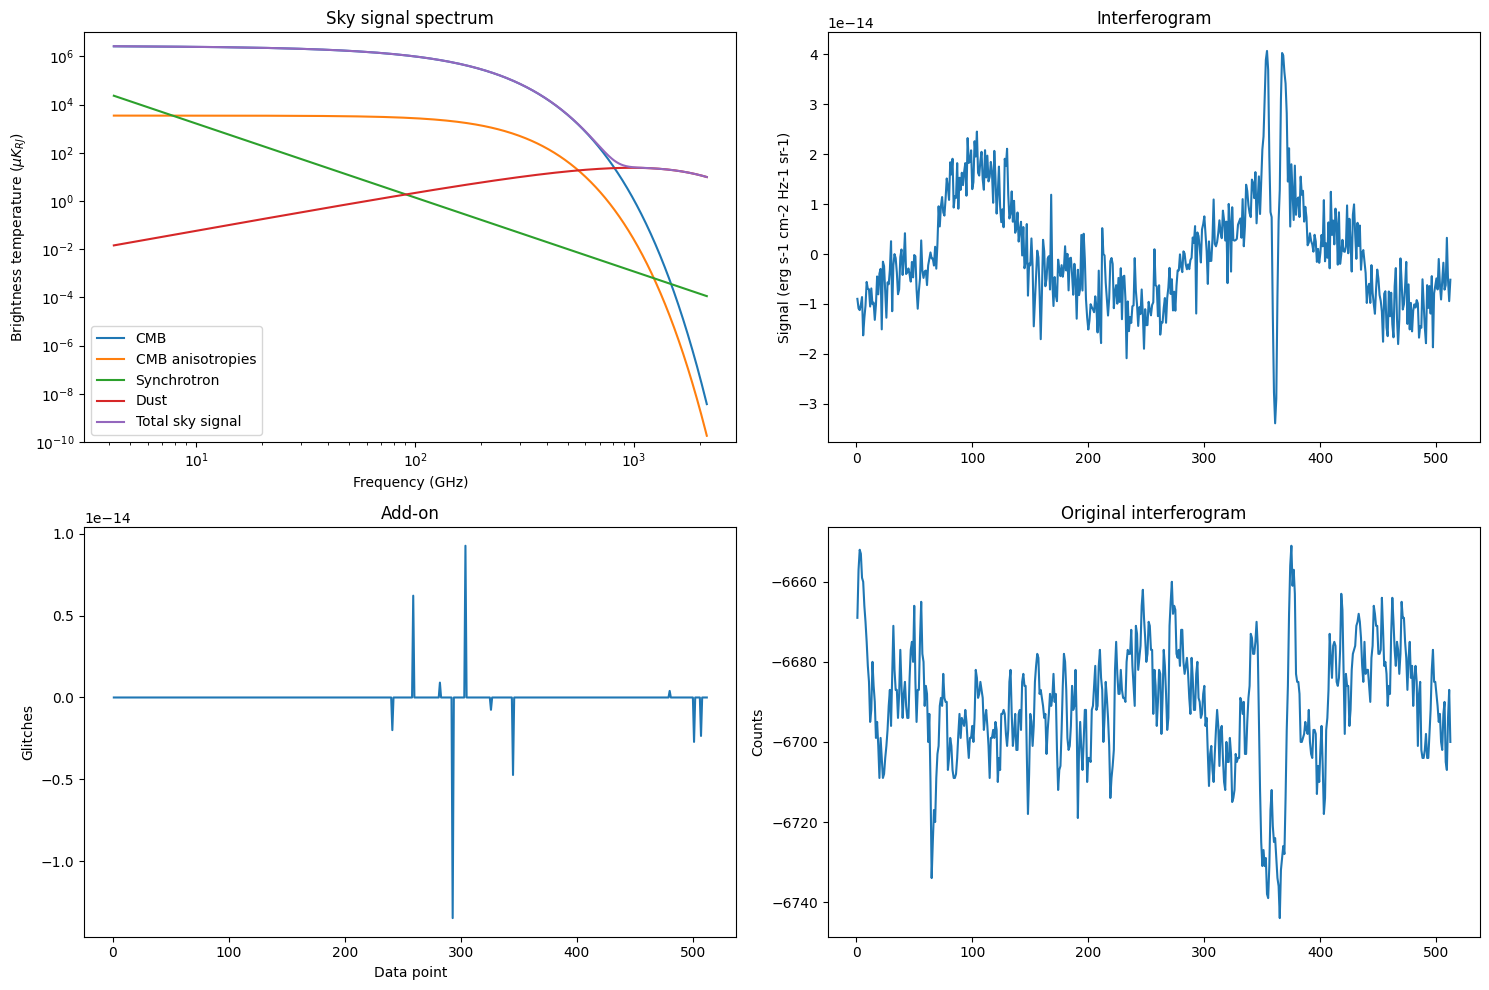

In [40]:
fig, ax = plt.subplots(2,2, figsize=(15,10))

ax[0,0].plot(f_GHz, bb_cmb, label="CMB")
ax[0,0].plot(f_GHz, cmb_anisotropies, label="CMB anisotropies")
ax[0,0].plot(f_GHz, synchrotron, label="Synchrotron")
ax[0,0].plot(f_GHz, dust, label="Dust")
ax[0,0].plot(f_GHz, sky, label="Total sky signal")
ax[0,0].set_xlabel("Frequency (GHz)")
ax[0,0].set_ylabel("Brightness temperature ($\mu K_{RJ}$)")
ax[0,0].set_title("Sky signal spectrum")
ax[0,0].set_xscale("log")
ax[0,0].set_yscale("log")
ax[0,0].set_ylim(1e-10,1e7)
ax[0,0].legend()

ax[1,0].plot(x, glitch_curve)
ax[1,0].set_title("Add-on")
ax[1,0].set_xlabel("Data point")
ax[1,0].set_ylabel("Glitches")

ax[0,1].plot(x, ifg)
# ax[1].set_xlabel("Optical path (cm)")
ax[0,1].set_ylabel("Signal (erg s-1 cm-2 Hz-1 sr-1)")
ax[0,1].set_title("Interferogram")
# ax[0,1].set_ylim(-6e-12, 5e-12)

ax[1,1].plot(x, original_ifg)
# ax[2].set_xlabel("Optical path (cm)")
ax[1,1].set_ylabel("Counts")
ax[1,1].set_title("Original interferogram")

plt.tight_layout()
plt.show()